# ML Enabled Lumberton CGE


## 1. Building Damage Analysis

The following code is preparing the IN-CORE analysis by checking versions and connecting to IN-CORE web service.


In [1]:
from pyincore import IncoreClient, Dataset, FragilityService, MappingSet, DataService
from pyincore.analyses.buildingdamage import BuildingDamage
from pyincore.analyses.cumulativebuildingdamage import CumulativeBuildingDamage
from pyincore.analyses.montecarlofailureprobability import MonteCarloFailureProbability

import os
import pandas as pd
import numpy as np
import geopandas as gpd  # For reading in shapefiles
import matplotlib.pyplot as plt
from IPython.display import display

import sys  # For displaying package versions
import os  # For managing directories and file paths if drive is mounted

from pyincore_viz.geoutil import GeoUtil as viz
from pyincore_viz.plotutil import PlotUtil as plot

client = IncoreClient()
client.clear_cache()

Connection successful to IN-CORE services. pyIncore version detected: 1.21.0


In [2]:
# create data_service object for loading files
data_service = DataService(client)

In [3]:
# Check package versions - good practice for replication
print("Python Version ", sys.version)
print("pandas version: ", pd.__version__)
print("numpy version: ", np.__version__)

Python Version  3.11.6 | packaged by conda-forge | (main, Oct  3 2023, 10:37:07) [Clang 15.0.7 ]
pandas version:  2.2.3
numpy version:  1.26.4


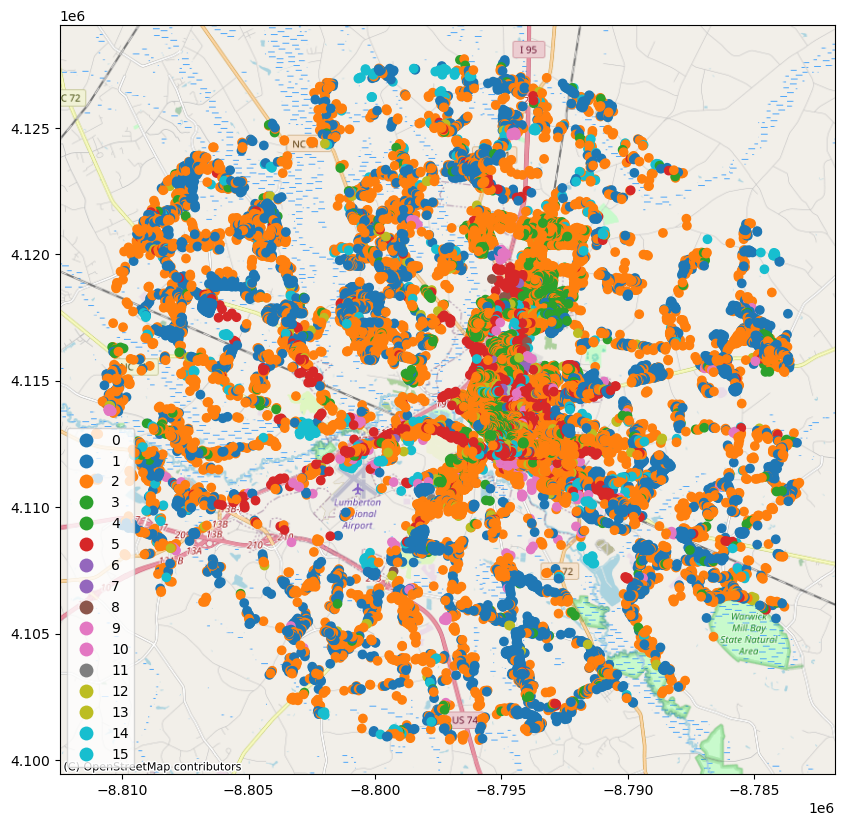

In [4]:
# Lumberton Building Inventory from IN-CORE
Building_Inventory_id = "688847618713de21d280ddac"

# visualize the building inventory
Lumberton_Building_Inventory = Dataset.from_data_service(
    Building_Inventory_id, DataService(client)
)
viz.plot_map(
    Lumberton_Building_Inventory, column="archetype", category=True, basemap=True
)

In [5]:
### This CELL will be removed in the future
building_to_sectors_id = "688836b1bea18707df6e3178"
building_to_sectors_df = Dataset.from_data_service(
    building_to_sectors_id, DataService(client)
).get_dataframe_from_csv()


lumberton_df = Lumberton_Building_Inventory.get_dataframe_from_shapefile()
# check the columns in the building inventory
print("Columns in the building inventory: ", lumberton_df.columns)
# check the columns in the building to sectors
print("Columns in the building to sectors: ", building_to_sectors_df.columns)
# join based on guid
matching = lumberton_df.merge(building_to_sectors_df, on="guid", how="left")
# matching = lumberton_df.join(
#     building_to_sectors_df, on="guid", how="left"
# )
print("number of buildings in the inventory: ", len(lumberton_df))
print("Number of buildings in the inventory: ", len(matching))
print((lumberton_df["appr_bldg"] > 0).sum())

Columns in the building inventory:  Index(['guid', 'strctid', 'ffe_elev', 'archetype', 'parid', 'struct_typ',
       'no_stories', 'a_stories', 'b_stories', 'bsmt_type', 'sq_foot',
       'gsq_foot', 'occ_type', 'occ_detail', 'major_occ', 'broad_occ',
       'repl_cst', 'str_cst', 'nstra_cst', 'nstrd_cst', 'dgn_lvl', 'cont_val',
       'efacility', 'dwell_unit', 'str_typ2', 'occ_typ2', 'appr_land',
       'appr_tot', 'year_built', 'lhsm_elev', 'g_elev', 'arch_flood',
       'appr_bldg', 'geometry'],
      dtype='object')
Columns in the building to sectors:  Index(['guid', 'sector'], dtype='object')
number of buildings in the inventory:  20087
Number of buildings in the inventory:  20087
20039


In [6]:
# Flood building archetypes mapping
mapping_id = "602f3cf981bd2c09ad8f4f9d"
fragility_service = FragilityService(client)
mapping_set = MappingSet(fragility_service.get_mapping(mapping_id))

In [7]:
# Reading the Hazard type and the Hazard ID
hazard_type = "flood"
hazard_id = "5f5916456f515f55ee30a5f0"

### 1.2 Building Damage Analysis


In [8]:
bldg_dmg = BuildingDamage(client)

bldg_dmg.load_remote_input_dataset("buildings", Building_Inventory_id)
bldg_dmg.set_input_dataset("dfr3_mapping_set", mapping_set)

Dataset already exists locally. Reading from local cached zip.
Unzipped folder found in the local cache. Reading from it...


/var/folders/5g/tg857l957nz_jnxdsyqsqxc80000gr/T/ipykernel_43848/577872555.py:1: DeprecationWarning: Call to deprecated class BuildingDamage. (This class will be deprecated soon. Use BuildingStructuralDamage instead.) -- Deprecated since version 1.19.0.
  bldg_dmg = BuildingDamage(client)


True

In [9]:
# Run the building damage analysis
result_name = "Lumberton_bldg_flood_dmg_result"

bldg_dmg.set_parameter("fragility_key", "Lumberton Flood Building Fragility ID Code")
bldg_dmg.set_parameter("result_name", result_name)
bldg_dmg.set_parameter("hazard_type", hazard_type)
bldg_dmg.set_parameter("hazard_id", hazard_id)
bldg_dmg.set_parameter("num_cpu", 4)
bldg_dmg.run_analysis()

True

The following code explores the buildings damage analysis results


In [10]:
# Retrieve result dataset
building_dmg_result = bldg_dmg.get_output_dataset("ds_result")

In [11]:
# Convert dataset to Pandas DataFrame
bdmg_df = building_dmg_result.get_dataframe_from_csv(low_memory=False)

# Display top 5 rows of output data
bdmg_df.head()

,guid,LS_0,LS_1,LS_2,DS_0,DS_1,DS_2,DS_3,haz_expose
0,efd13166-d7a0-476b-ada5-c55cea1f0184,0.0,0.0,0.0,1.0,0.0,0.0,0.0,no
1,66352d95-70cb-46cb-8904-576f3ee3e9d3,0.0,0.0,0.0,1.0,0.0,0.0,0.0,no
2,a4fb314f-0e00-4bf1-9651-d8ecaa4b14d8,0.0,0.0,0.0,1.0,0.0,0.0,0.0,no
3,e433891c-aa7a-47b0-a6aa-1b0895a65908,0.0,0.0,0.0,1.0,0.0,0.0,0.0,no
4,7afe36f4-fb23-43c6-b1f9-3e6d3209dcbc,0.0,0.0,0.0,1.0,0.0,0.0,0.0,no


## 2. Montecarlo Limit State Probability


In [12]:
from pyincore.analyses.montecarlofailureprobability import MonteCarloFailureProbability

In [13]:
num_samples = (
    500  # Require 500 samples for convergence - Selected smaller samples for testing
)
result_name = "Lumberton_mc_failure_probability_buildings_dmg_result"

mc_bldg = MonteCarloFailureProbability(client)

mc_bldg.set_input_dataset("damage", building_dmg_result)
mc_bldg.set_parameter("num_cpu", 8)
mc_bldg.set_parameter("num_samples", num_samples)
mc_bldg.set_parameter("damage_interval_keys", ["DS_0", "DS_1", "DS_2", "DS_3"])
mc_bldg.set_parameter("failure_state_keys", ["DS_2", "DS_3"])

mc_bldg.set_parameter("result_name", result_name)

/var/folders/5g/tg857l957nz_jnxdsyqsqxc80000gr/T/ipykernel_43848/3357064748.py:6: DeprecationWarning: Call to deprecated class MonteCarloFailureProbability. (This class is deprecated. Use MonteCarloLimitStateProbability instead.) -- Deprecated since version 1.19.0.
  mc_bldg = MonteCarloFailureProbability(client)


True

In [14]:
mc_bldg.run_analysis()

# Obtain buildings failure probabilities
building_failure_probability = mc_bldg.get_output_dataset("failure_probability")

df_bldg_fail = building_failure_probability.get_dataframe_from_csv()
df_bldg_fail.head()

cannot determine MC damage state!
cannot determine MC damage state!
cannot determine MC damage state!
cannot determine MC damage state!
cannot determine MC damage state!
cannot determine MC damage state!
cannot determine MC damage state!
cannot determine MC damage state!
cannot determine MC damage state!
cannot determine MC damage state!
cannot determine MC damage state!
cannot determine MC damage state!
cannot determine MC damage state!
cannot determine MC damage state!
cannot determine MC damage state!
cannot determine MC damage state!
cannot determine MC damage state!
cannot determine MC damage state!
cannot determine MC damage state!
cannot determine MC damage state!
cannot determine MC damage state!
cannot determine MC damage state!
cannot determine MC damage state!


,guid,failure_probability
0,efd13166-d7a0-476b-ada5-c55cea1f0184,0.0
1,66352d95-70cb-46cb-8904-576f3ee3e9d3,0.0
2,a4fb314f-0e00-4bf1-9651-d8ecaa4b14d8,0.0
3,e433891c-aa7a-47b0-a6aa-1b0895a65908,0.0
4,7afe36f4-fb23-43c6-b1f9-3e6d3209dcbc,0.0


In [15]:
(df_bldg_fail["failure_probability"] > 0).sum()

1997

In [16]:
# Obtain buildings sample damage states
sample_damage_states = mc_bldg.get_output_dataset("sample_damage_states")
df_bldg_ds = sample_damage_states.get_dataframe_from_csv()
df_bldg_ds.head()

,guid,sample_damage_states
0,efd13166-d7a0-476b-ada5-c55cea1f0184,"DS_0,DS_0,DS_0,DS_0,DS_0,DS_0,DS_0,DS_0,DS_0,D..."
1,66352d95-70cb-46cb-8904-576f3ee3e9d3,"DS_0,DS_0,DS_0,DS_0,DS_0,DS_0,DS_0,DS_0,DS_0,D..."
2,a4fb314f-0e00-4bf1-9651-d8ecaa4b14d8,"DS_0,DS_0,DS_0,DS_0,DS_0,DS_0,DS_0,DS_0,DS_0,D..."
3,e433891c-aa7a-47b0-a6aa-1b0895a65908,"DS_0,DS_0,DS_0,DS_0,DS_0,DS_0,DS_0,DS_0,DS_0,D..."
4,7afe36f4-fb23-43c6-b1f9-3e6d3209dcbc,"DS_0,DS_0,DS_0,DS_0,DS_0,DS_0,DS_0,DS_0,DS_0,D..."


In [17]:
building_damage_mcs_samples = mc_bldg.get_output_dataset(
    "sample_failure_state"
)  # get buildings failure states

bdmcs = building_damage_mcs_samples.get_dataframe_from_csv()
bdmcs.head()

,guid,failure
0,efd13166-d7a0-476b-ada5-c55cea1f0184,"1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,..."
1,66352d95-70cb-46cb-8904-576f3ee3e9d3,"1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,..."
2,a4fb314f-0e00-4bf1-9651-d8ecaa4b14d8,"1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,..."
3,e433891c-aa7a-47b0-a6aa-1b0895a65908,"1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,..."
4,7afe36f4-fb23-43c6-b1f9-3e6d3209dcbc,"1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,..."


# 3. Capital Stock Shock and CGE Analysis


In [18]:
from pyincore.analyses.capitalshocks import CapitalShocks

In [19]:
# Joplin building to sector mapping table
building_to_sectors_id = "688836b1bea18707df6e3178"
# Create Capital shocks analysis
capital_shocks = CapitalShocks(client)

# Load remote datasets
capital_shocks.load_remote_input_dataset("buildings_to_sectors", building_to_sectors_id)
# Set datasets
# Joplin building inventory
capital_shocks.load_remote_input_dataset("buildings", Building_Inventory_id)
# Joplin building failure probability
capital_shocks.set_input_dataset("failure_probability", building_failure_probability)

capital_shocks.set_parameter(
    "result_name", "sector_shocks"
)  # name of csv file with results

Dataset already exists locally. Reading from local cached zip.
Unzipped folder found in the local cache. Reading from it...
Dataset already exists locally. Reading from local cached zip.
Unzipped folder found in the local cache. Reading from it...


True

In [20]:
# Run capital shocks analysis
capital_shocks.run_analysis()

sector_shocks_result = capital_shocks.get_output_dataset("sector_shocks")
sector_shocks_result.get_dataframe_from_csv()

(19982, 36)
['FINANCEA' 'OTHERA' 'ADMINA' 'RETAILA' 'REALEA' 'ACCOA' 'HS2A' 'HS3A'
 'HS4A' 'HEALTHA' 'UTILA' 'EDUA' 'TRANSA' 'HS1A' 'ARTA' 'PRO_MANA' 'MANUA'
 'WHOLEA' 'CONSTA' 'AG_MIA' 'INFOA' 'AG_MIB' 'UTILB' 'CONSTB' 'MANUB'
 'WHOLEB' 'RETAILB' 'TRANSB' 'INFOB' 'FINANCEB' 'REALEB' 'PRO_MANB'
 'ADMINB' 'EDUB' 'HEALTHB' 'ARTB' 'ACCOB' 'OTHERB' 'HS1B' 'HS2B' 'HS3B'
 'HS4B']
FINANCEA
(94, 36)
Index(['a_stories', 'appr_bldg', 'appr_land', 'appr_tot', 'arch_flood',
       'archetype', 'b_stories', 'broad_occ', 'bsmt_type', 'cont_val',
       'dgn_lvl', 'dwell_unit', 'efacility', 'ffe_elev', 'g_elev', 'gsq_foot',
       'guid', 'lhsm_elev', 'major_occ', 'no_stories', 'nstra_cst',
       'nstrd_cst', 'occ_detail', 'occ_typ2', 'occ_type', 'parid', 'repl_cst',
       'sq_foot', 'str_cst', 'str_typ2', 'strctid', 'struct_typ', 'year_built',
       'failure_probability', 'sector', 'cap_rem'],
      dtype='object')
False
92988921.212512 94099981.828
OTHERA
(573, 36)
Index(['a_stories', 'appr_bldg

,sector,shock
0,FINANCEA,0.988193
1,OTHERA,0.971979
2,ADMINA,0.999310
3,RETAILA,0.988523
4,REALEA,0.983281
5,ACCOA,0.986106
6,HS2A,0.964546
7,HS3A,0.977223
8,HS4A,0.986154
9,HEALTHA,0.990217


### 4. ML Enabled CGE - Lumberton


In [ ]:
from pyincore.analyses.mlenabledcgelumberton import MlEnabledCgeLumberton

In [ ]:
mlcgelumberton = MlEnabledCgeLumberton(client)
mlcgelumberton.set_input_dataset("sector_shocks", sector_shocks_result)
mlcgelumberton.set_parameter("result_name", "test_lumberton_mlcge_result")

In [ ]:
mlcgelumberton.run_analysis()